In [1]:
from transformers import Qwen2_5OmniForConditionalGeneration, Qwen2_5OmniProcessor
from qwen_omni_utils import process_mm_info
import torch
import soundfile as sf
import os
import matplotlib.pyplot as plt
from PIL import Image

# --- 强制显示 Hugging Face Hub 下载进度条 ---
# os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" # 启用并行下载器，通常更快
# os.environ["HF_HUB_PROGRESS"] = "1"         # 强制显示进度条

# 加载模型和处理器
model = Qwen2_5OmniForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-Omni-3B",
    torch_dtype="auto",
    device_map="cuda",
    attn_implementation="flash_attention_2",  # 使用 Flash Attention 2
)
model.disable_talker()
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-3B")

# img_path = "../img/BlueUp1.jpg"
# image = Image.open(img_path).convert("RGB")
# image = image.resize((224, 224))  # 或者 (384, 384)
# image.save("resized.jpg")

# conversation = [
#     {
#         "role": "system",
#         "content": [{"type": "text", "text": "You are a helpful assistant that can understand images and answer questions."}],
#     },
#     {
#         "role": "user",
#        
# "content": [
#             {"type": "image", "image": "resized.jpg"},
#             {"type": "text", "text": "Descirbe objects and their relative locations in details: "}
#         ],
#     },
# ]


# # 如果不涉及音频，设为 False
# USE_AUDIO_IN_VIDEO = False

# # 准备推理输入
# text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
# audios, images, videos = process_mm_info(conversation, use_audio_in_video=USE_AUDIO_IN_VIDEO)
# inputs = processor(
#     text=text,
#     audio=audios,
#     images=images,
#     videos=videos,
#     return_tensors="pt",
#     padding=True,
#     use_audio_in_video=USE_AUDIO_IN_VIDEO,
# )
# inputs = inputs.to(model.device).to(model.dtype)

# # 推理（仅生成文字，无需语音时可不保存 audio）
# # text_ids, _ = model.generate(**inputs, use_audio_in_video=USE_AUDIO_IN_VIDEO)

# text_ids = model.generate(
#     **inputs,
#     use_audio_in_video=False,           # 不启用音频
#     return_audio=False, # 不返回音频
#     max_new_tokens=20,                  # 限制输出长度
#     do_sample=True,                     # 采样生成（非贪心）
#     temperature=0.7,                    # 控制多样性
#     top_p=0.9,                          # nucleus sampling
#     repetition_penalty=1.1             # 减少重复输出
# )


# output_text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
# print(output_text)


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
Qwen2_5OmniToken2WavModel must inference with fp32, but flash_attention_2 only supports fp16 and bf16, attention implementation of Qwen2_5OmniToken2WavModel will fallback to sdpa.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


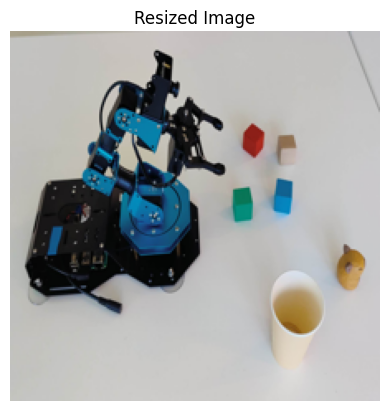

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x735D3BBBEBE0>], videos: None
GenerationConfig {}

system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in 10 words:
assistant
Blue robot, red block, green cube, white cup, wooden ball, assorted blocks scattered on white surface.


In [2]:
def inference_img(img_path, 
                system_prompt="You are a helpful assistant that can understand images and answer questions.", 
                user_prompt="Describe objects and their relative locations in details: ",
                resize_location="resized.jpg",
                resieze_size=(224, 224)):
    img_path = img_path
    image = Image.open(img_path).convert("RGB")
    image = image.resize(resieze_size) 
    image.save(resize_location)
    
    # plot resized image
    plt.imshow(image)
    plt.axis('off')  # 去掉坐标轴
    plt.title("Resized Image")
    plt.show()
    
    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": resize_location},
                {"type": "text", "text": user_prompt}
            ],
        },
    ]

    if_return_audio = False  # 如果不涉及音频，设为 False
    # 准备推理输入
    text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
    audios, images, videos = process_mm_info(conversation, use_audio_in_video=if_return_audio)
    print(f"audios: {audios}, images: {images}, videos: {videos}")
    inputs = processor(
        text=text,
        audio=audios,
        images=images,
        videos=videos,
        return_tensors="pt",
        padding=True,
        use_audio_in_video=if_return_audio,
    )
    inputs = inputs.to(model.device).to(model.dtype)

    text_ids = model.generate(
        **inputs,
        use_audio_in_video=if_return_audio,           # 不启用音频
        return_audio=False,                 # 不返回音频
        # max_new_tokens=50,                # 限制输出长度
        # max_length=10, 
        do_sample=True,                     # 采样生成（非贪心）
        temperature=0.5,                    # 控制多样性
        top_p=0.9,                          # nucleus sampling
        repetition_penalty=1.1              # 减少重复输出
    )

    print(model.generation_config)
    output_text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print(output_text)
    
inference_img(img_path="../img/img1.jpg", user_prompt="Describe objects and their relative locations in 10 words:")

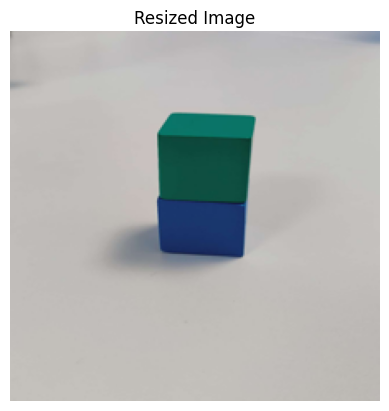

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x735D3BED93B0>], videos: None
GenerationConfig {}

system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in details: 
assistant
The image shows two cubes stacked on top of each other. The cube at the bottom is blue, while the one on top is green. Both cubes have a smooth surface and are placed against a plain white background. There is no additional context or elements present in the image.


In [30]:
inference_img(img_path="../img/GreenUp1.jpg")

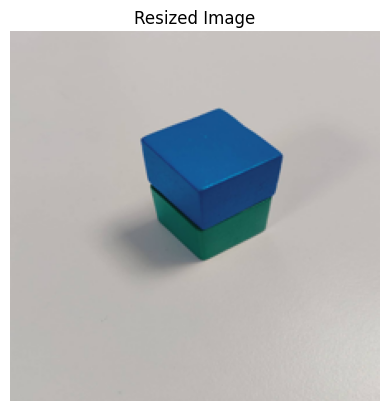

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x735D3BCE65D0>], videos: None
GenerationConfig {}

system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in brief with 1 sentence: DO NOT describe background/surface: for example: A red phone is under a wood mouse. ; Only one red cup.
assistant
A blue cube is on top of a green cube.


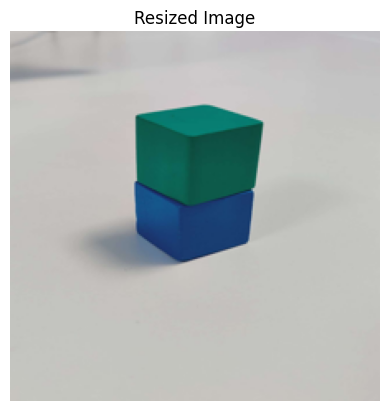

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x735D3B126990>], videos: None
GenerationConfig {}

system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in brief with 1 sentence: DO NOT describe background/surface: for example: A red phone is under a wood mouse. ; Only one red cup.
assistant
A green cube sits atop a blue cube.


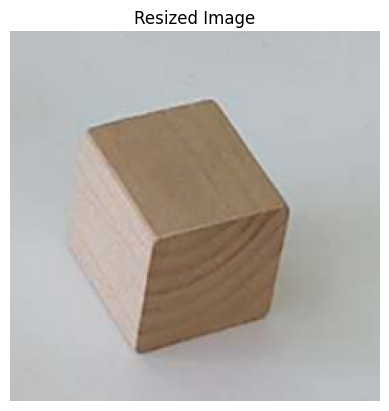

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x735D3BAD3C50>], videos: None
GenerationConfig {}

system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in brief with 1 sentence: DO NOT describe background/surface: for example: A red phone is under a wood mouse. ; Only one red cup.
assistant
A wooden block is placed on a white surface.


In [38]:
user_prompt="Describe object(s) and their relative locations in 1 sentences: DO NOT describe background/surface/flat, for example: A red phone is under a wood mouse. ; Only one red cup."
user_prompt = "Describe objects and their relative locations in brief with 1 sentence: DO NOT describe background/surface: for example: A red phone is under a wood mouse. ; Only one red cup."
inference_img(img_path="../img/BlueUp1.jpg", user_prompt=user_prompt)
inference_img(img_path="../img/GreenUp2.jpg", user_prompt=user_prompt)
inference_img(img_path="../img/wood_cube_1.png", user_prompt=user_prompt)

In [ ]:
inference_img(img_path="../img/BlueUp2.jpg") 

In [ ]:
user_prompt="Describe objects and relative locations in brief: "

inference_img(img_path="../img/BlueUp2.jpg",user_prompt =user_prompt) 

In [ ]:
user_prompt = (
    "Identify the green object, describe all objects and their relative locations. "
    "If any objects are blocking the path for a robotic arm to grasp green objects, "
    "provide a step-by-step strategy to remove or relocate the obstacles. "
    "Then, describe how the robotic arm should pick up the green object safely."
)

inference_img(img_path="../img/BlueUp2.jpg",user_prompt =user_prompt) 

音频：无，图像：[<PIL.Image.Image image mode=RGB size=224x224 at 0x768E747A22B0>]，视频：无 <br>
系统<br>
你是一位能够理解图像并回答问题的助手。<br>
用户<br>
识别绿色物体，描述所有物体及其相对位置。如果任何物体阻挡了机械臂抓取绿色物体的路径，请提供逐步移除或重新定位障碍物的策略。然后，描述机械臂如何安全地拾取绿色物体。<br>
助手<br>
图片显示了两个立方体：一个蓝色，一个绿色。蓝色立方体位于绿色立方体上方。<br>

### 障碍物：<br>
1. **蓝色立方体**：阻挡了机械臂到绿色立方体的直接路径。<br>
2. **白色表面**：如果机械臂需要绕过两个立方体，则两个立方体所在的表面可能成为障碍。<br>

### 策略：<br>
1. **移动蓝色立方体**：使用机械臂将蓝色立方体稍微抬离绿色立方体。这将在两个立方体之间留出空间。<br>
2. **重新定位绿色立方体**：抬起蓝色立方体后，使用机械臂轻轻地将绿色立方体向前或向侧面推，以清理障碍物。<br>
3. **清理白色表面**：如果白色表面构成障碍物，机械臂可以通过沿着边缘移动或将其抬起来小心地绕过它。<br>
<br>
### 安全拾取流程：<br>
1. **抬起绿色立方体**：小心地将机械臂向下朝向绿色立方体，并轻轻抓住其底部。<br>
2. **支撑立方体**：确保机械臂牢固地支撑立方体，不要施加过大的力，以免损坏立方体或机器人本身。<br>
3. **运送到目的地**：使用机械臂的受控运动将绿色立方体移动到所需位置。<br>

通过遵循这些步骤，机械臂可以安全有效地拾取绿色立方体，而不会受到任何阻碍。<br>

In [ ]:
user_prompt = (
    "Identify the green object and describe its environments. "
    "If any objects are blocking the path for a robotic arm to grasp it, "
    "provide a step-by-step strategy to pick up the green object safely."
)

inference_img(img_path="../img/BlueUp2.jpg",user_prompt =user_prompt) 

上面的描述，只能理解到要小心，但是不能理解到要先挪开蓝色

In [ ]:
# img_path = "../img/BlueUp5.jpg"
# image = Image.open(img_path).convert("RGB")
# image = image.resize((224, 224))  # 或者 (384, 384)
# image.save("resized.jpg")

# conversation = [
#     {
#         "role": "system",
#         "content": [{"type": "text", "text": "You are a helpful assistant that can understand images and answer questions."}],
#     },
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "image": "resized.jpg"},
#             {"type": "text", "text": "Descirbe objects and their relative locations in details: "}
#         ],
#     },
# ]


# # 如果不涉及音频，设为 False
# USE_AUDIO_IN_VIDEO = False

# # 准备推理输入
# text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
# audios, images, videos = process_mm_info(conversation, use_audio_in_video=USE_AUDIO_IN_VIDEO)
# inputs = processor(
#     text=text,
#     audio=audios,
#     images=images,
#     videos=videos,
#     return_tensors="pt",
#     padding=True,
#     use_audio_in_video=USE_AUDIO_IN_VIDEO,
# )
# inputs = inputs.to(model.device).to(model.dtype)

# # 推理（仅生成文字，无需语音时可不保存 audio）
# # text_ids, _ = model.generate(**inputs, use_audio_in_video=USE_AUDIO_IN_VIDEO)

# text_ids = model.generate(
#     **inputs,
#     use_audio_in_video=False,           # 不启用音频
#     return_audio=False, # 不返回音频
#     # max_new_tokens=20,                  # 限制输出长度
#     do_sample=True,                     # 采样生成（非贪心）
#     temperature=0.7,                    # 控制多样性
#     top_p=0.9,                          # nucleus sampling
#     repetition_penalty=1.1             # 减少重复输出
# )


# output_text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
# print(output_text)